In [ ]:
#Phase 3 - NovaQ Neurophysiology (NQN) Spike Sorting Pipeline
#Data Load: file sub-P29-16-05-14-retina02-left_ecephys.nwb from https://dandiarchive.org/dandiset/000034/0.211030.0713/files?location=sub-P29-16-05-14-retina02-left&page=1


In [ ]:
from pynwb import NWBHDF5IO

# Path to your NWB file
nwb_path = r"../sub_P29_16_05_14_retina02_left_ecephys.nwb"

# Open the NWB file
with NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()

    print("\nAvailable acquisition keys:")
    acquisition_keys = list(nwbfile.acquisition.keys())
    for key in acquisition_keys:
        print(" -", key)

    # Try to find the first ElectricalSeries key
    electrical_series = None
    for key in acquisition_keys:
        obj = nwbfile.acquisition[key]
        if 'ElectricalSeries' in str(type(obj)):
            electrical_series = obj
            print(f"\n✅ Found ElectricalSeries under key: '{key}'")
            break

    if electrical_series is not None:
        data_shape = electrical_series.data.shape
        print(f"\n📐 Shape of electrical data: {data_shape}")
        print(f"   → Time samples: {data_shape[0]}")
        print(f"   → Channels: {data_shape[1]}")
    else:
        print("\n⚠️ No ElectricalSeries found in acquisition.")



Available acquisition keys:
 - ElectricalSeries

✅ Found ElectricalSeries under key: 'ElectricalSeries'

📐 Shape of electrical data: (3148820, 1024)
   → Time samples: 3148820
   → Channels: 1024


In [ ]:
#step 1- Load the  nwb file and pull sampling time frame for channel data to be pulled
from spikeinterface.extractors import read_nwb_recording
import spikeinterface.preprocessing as spre
import numpy as np

nwb_path = r"../sub_P29_16_05_14_retina02_left_ecephys.nwb"
recording = read_nwb_recording(nwb_path)

# Use first 60 seconds only
fs = recording.get_sampling_frequency()
recording = recording.frame_slice(start_frame=0, end_frame=int(fs * 60))
print(f"Recording loaded at {fs} Hz")


Recording loaded at 23199.090358491783 Hz


In [33]:
#Step2- Preprocessing and chunking setup
# Apply bandpass + common reference
# Apply filtering and reference
#Hardware restrictions(memory restrictions) reduced the sampling size from 5s to 2s 
recording = spre.bandpass_filter(recording, freq_min=300, freq_max=6000)
recording = spre.common_reference(recording, reference='global')

chunk_duration_sec = 2
bin_size_ms = 1
bin_size_samples = int(fs * (bin_size_ms / 1000))
samples_per_chunk = int(fs * chunk_duration_sec)
total_samples = recording.get_num_frames()
num_chunks = total_samples // samples_per_chunk

print(f"Processing {num_chunks} chunks of {chunk_duration_sec} seconds each.")


Processing 30 chunks of 2 seconds each.


In [40]:
binned_chunks = []

for chunk_idx in range(num_chunks):
    start = chunk_idx * samples_per_chunk
    end = start + samples_per_chunk
    print(f"→ Processing chunk {chunk_idx+1}/{num_chunks}...")

    traces = recording.get_traces(start_frame=start, end_frame=end)
    threshold = 5 * np.std(traces)
    binary_spikes = (traces > threshold).astype(np.uint8)

    chunk_binned = np.array([
        np.max(binary_spikes[i:i + bin_size_samples], axis=0)
        for i in range(0, binary_spikes.shape[0], bin_size_samples)
    ])
    binned_chunks.append(chunk_binned)

print("✅ All chunks processed.")


→ Processing chunk 1/30...


→ Processing chunk 2/30...
→ Processing chunk 3/30...
→ Processing chunk 4/30...
→ Processing chunk 5/30...
→ Processing chunk 6/30...
→ Processing chunk 7/30...
→ Processing chunk 8/30...
→ Processing chunk 9/30...
→ Processing chunk 10/30...
→ Processing chunk 11/30...
→ Processing chunk 12/30...
→ Processing chunk 13/30...
→ Processing chunk 14/30...
→ Processing chunk 15/30...
→ Processing chunk 16/30...
→ Processing chunk 17/30...
→ Processing chunk 18/30...
→ Processing chunk 19/30...
→ Processing chunk 20/30...
→ Processing chunk 21/30...
→ Processing chunk 22/30...
→ Processing chunk 23/30...
→ Processing chunk 24/30...
→ Processing chunk 25/30...
→ Processing chunk 26/30...
→ Processing chunk 27/30...
→ Processing chunk 28/30...
→ Processing chunk 29/30...
→ Processing chunk 30/30...
✅ All chunks processed.


In [41]:
# Concatenate along time axis
final_binned = np.concatenate(binned_chunks, axis=0).T  # shape: (channels, time)
final_tensor = np.expand_dims(final_binned, axis=0)     # shape: (1, channels, time)

print(f"Final tensor shape: {final_tensor.shape}")
np.save("binned_spike_tensor_256ch.npy", final_tensor)
print("✅ Saved to binned_spike_tensor_256ch.npy")


Final tensor shape: (1, 1024, 60540)
✅ Saved to binned_spike_tensor_256ch.npy


In [42]:
#Cell 1: Load binned spike tensor
import numpy as np
import torch

# Load saved binned spike tensor
data = np.load("binned_spike_tensor_256ch.npy")
print("Loaded shape:", data.shape)  # (1, 256, 60540)

# Convert to PyTorch tensor
spike_tensor = torch.tensor(data, dtype=torch.float32)
print("Torch shape:", spike_tensor.shape)


Loaded shape: (1, 1024, 60540)


Torch shape: torch.Size([1, 1024, 60540])


In [44]:
# Step 3 — Segment the spike tensor by time and prepare for Conv1D over time
segment_len = 1000  # 1000 ms = 1 second segments

# Unfold along time → shape: (1, 256, num_segments, 1000)
segments = spike_tensor.unfold(dimension=2, size=segment_len, step=segment_len)

# Reshape to: (segments, channels, time) → then permute for Conv1D over time
segments = segments.squeeze(0).permute(0, 2, 1)  # (segments, time, channels)

print("Segmented shape for training:", segments.shape)  # (e.g., 60, 1000, 256)


Segmented shape for training: torch.Size([1024, 1000, 60])


In [45]:
#fixing the decoder
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Reload segments if needed
segments = torch.tensor(np.load("binned_spike_tensor_256ch.npy"), dtype=torch.float32)
segments = segments.unfold(dimension=2, size=1000, step=1000).squeeze(0).permute(0, 2, 1)  # shape: (256, 1000, 60)

# Define corrected autoencoder
class SpikeAutoencoder(nn.Module):
    def __init__(self, input_channels=60, embedding_dim=16):
        super(SpikeAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # (batch, 64, 1)
            nn.Flatten(),             # (batch, 64)
            nn.Linear(64, embedding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 64 * 10),
            nn.Unflatten(1, (64, 10)),  # → (batch, 64, 10)
            nn.ConvTranspose1d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, input_channels, kernel_size=5, padding=2),
            nn.Upsample(size=1000),  # restore time dimension
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)            # (batch, channels, time)
        z = self.encoder(x)               # (batch, embedding_dim)
        x_recon = self.decoder(z)         # (batch, channels, time)
        x_recon = x_recon.permute(0, 2, 1)  # back to (batch, time, channels)
        return x_recon, z

# Prepare DataLoader
dataset = TensorDataset(segments)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize model, optimizer, loss
model = SpikeAutoencoder(input_channels=segments.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
model.train()
for epoch in range(10):
    epoch_loss = 0.0
    for batch in loader:
        x = batch[0]  # shape: (batch, time, channels)
        x_recon, z = model(x)
        loss = loss_fn(x_recon, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f}")

# Save embeddings if needed
model.eval()
embeddings = []
with torch.no_grad():
    for batch in loader:
        x = batch[0]
        _, z = model(x)
        embeddings.append(z)

compressed = torch.cat(embeddings, dim=0).cpu().numpy()
np.save("compressed_embeddings.npy", compressed)
print("✅ Saved to compressed_embeddings.npy | Shape:", compressed.shape)


Epoch 1 | Loss: 1.8919
Epoch 2 | Loss: 0.2319
Epoch 3 | Loss: 0.2322
Epoch 4 | Loss: 0.2321
Epoch 5 | Loss: 0.2320
Epoch 6 | Loss: 0.2319
Epoch 7 | Loss: 0.2332
Epoch 8 | Loss: 0.2315
Epoch 9 | Loss: 0.2314
Epoch 10 | Loss: 0.2316
✅ Saved to compressed_embeddings.npy | Shape: (1024, 16)


In [ ]:
#dhawal will add validation loss 
#Training and Validation loss::

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split

# Load segments
segments = torch.tensor(np.load("binned_spike_tensor_256ch.npy"), dtype=torch.float32)
segments = segments.unfold(dimension=2, size=1000, step=1000).squeeze(0).permute(0, 2, 1)  # (256, 1000, 60)

# Define model
class SpikeAutoencoder(nn.Module):
    def __init__(self, input_channels=60, embedding_dim=16):
        super(SpikeAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(64, embedding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 64 * 10),
            nn.Unflatten(1, (64, 10)),
            nn.ConvTranspose1d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, input_channels, kernel_size=5, padding=2),
            nn.Upsample(size=1000),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        z = self.encoder(x)
        x_recon = self.decoder(z)
        x_recon = x_recon.permute(0, 2, 1)
        return x_recon, z

# Prepare dataset and split
dataset = TensorDataset(segments)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model, optimizer, loss
model = SpikeAutoencoder(input_channels=segments.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training + validation loop
model.train()
for epoch in range(10):
    train_loss = 0.0
    model.train()
    for batch in train_loader:
        x = batch[0]
        x_recon, z = model(x)
        loss = loss_fn(x_recon, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0]
            x_recon, z = model(x)
            loss = loss_fn(x_recon, x)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Save compressed embeddings for all data
model.eval()
embeddings = []
with torch.no_grad():
    for batch in DataLoader(dataset, batch_size=16):
        x = batch[0]
        _, z = model(x)
        embeddings.append(z)

compressed = torch.cat(embeddings, dim=0).cpu().numpy()
np.save("compressed_embeddings.npy", compressed)
print("✅ Saved to compressed_embeddings.npy | Shape:", compressed.shape)

Epoch 1 | Train Loss: 0.0323 | Val Loss: 0.0042
Epoch 2 | Train Loss: 0.0035 | Val Loss: 0.0043
Epoch 3 | Train Loss: 0.0036 | Val Loss: 0.0045
Epoch 4 | Train Loss: 0.0037 | Val Loss: 0.0045
Epoch 5 | Train Loss: 0.0036 | Val Loss: 0.0045
Epoch 6 | Train Loss: 0.0037 | Val Loss: 0.0045
Epoch 7 | Train Loss: 0.0037 | Val Loss: 0.0045
Epoch 8 | Train Loss: 0.0036 | Val Loss: 0.0045
Epoch 9 | Train Loss: 0.0037 | Val Loss: 0.0045
Epoch 10 | Train Loss: 0.0036 | Val Loss: 0.0045
✅ Saved to compressed_embeddings.npy | Shape: (1024, 16)


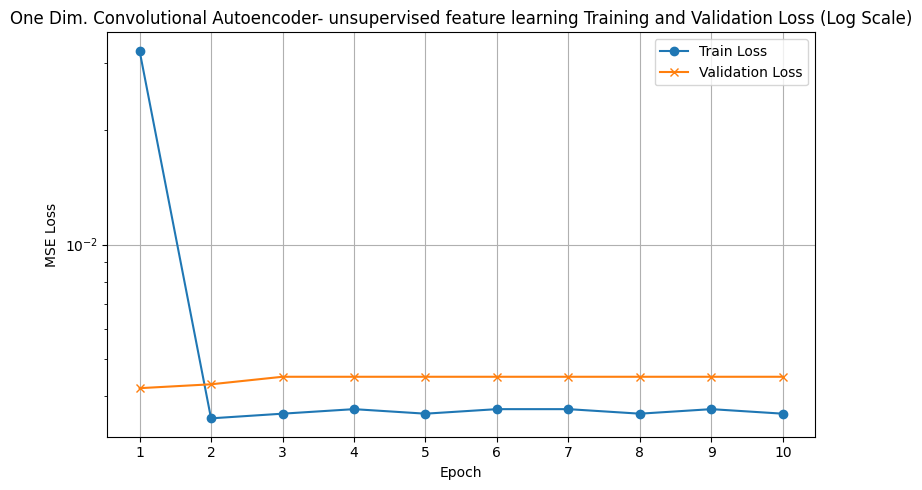

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Manually enter the loss values you reported
train_loss = np.array([0.0323, 0.0035, 0.0036, 0.0037, 0.0036,
                       0.0037, 0.0037, 0.0036, 0.0037, 0.0036])
val_loss   = np.array([0.0042, 0.0043, 0.0045, 0.0045, 0.0045,
                       0.0045, 0.0045, 0.0045, 0.0045, 0.0045])
epochs = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='x', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('One Dim. Convolutional Autoencoder- unsupervised feature learning Training and Validation Loss (Log Scale)')
plt.legend()
plt.grid(True)
plt.yscale('log')      # Log scale highlights small variations
plt.xticks(epochs)
plt.tight_layout()
plt.show()


In [21]:
#Quantum model imput will be the compressed_embeddins.npy
# Shape: [256, 16]  →  one 16-D vector per 1s segment
import qiskit
print(qiskit.__version__)


1.1.1


In [47]:
#Building a grgaph out of Spike embedings 
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

# Load compressed embeddings: shape (256, 16)
embeddings = np.load("compressed_embeddings.npy")

# Create a fully connected graph (or k-NN later)
G = nx.Graph()

# Add nodes and their 16-dim features
for i, feat in enumerate(embeddings):
    G.add_node(i, feature=feat)

# Add edges based on cosine similarity
similarity = cosine_similarity(embeddings)
threshold = 0.9  # you can tune this

for i in range(len(embeddings)):
    for j in range(i + 1, len(embeddings)):
        if similarity[i, j] > threshold:
            G.add_edge(i, j, weight=similarity[i, j])

print(f"✅ Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


✅ Graph built with 1024 nodes and 523776 edges


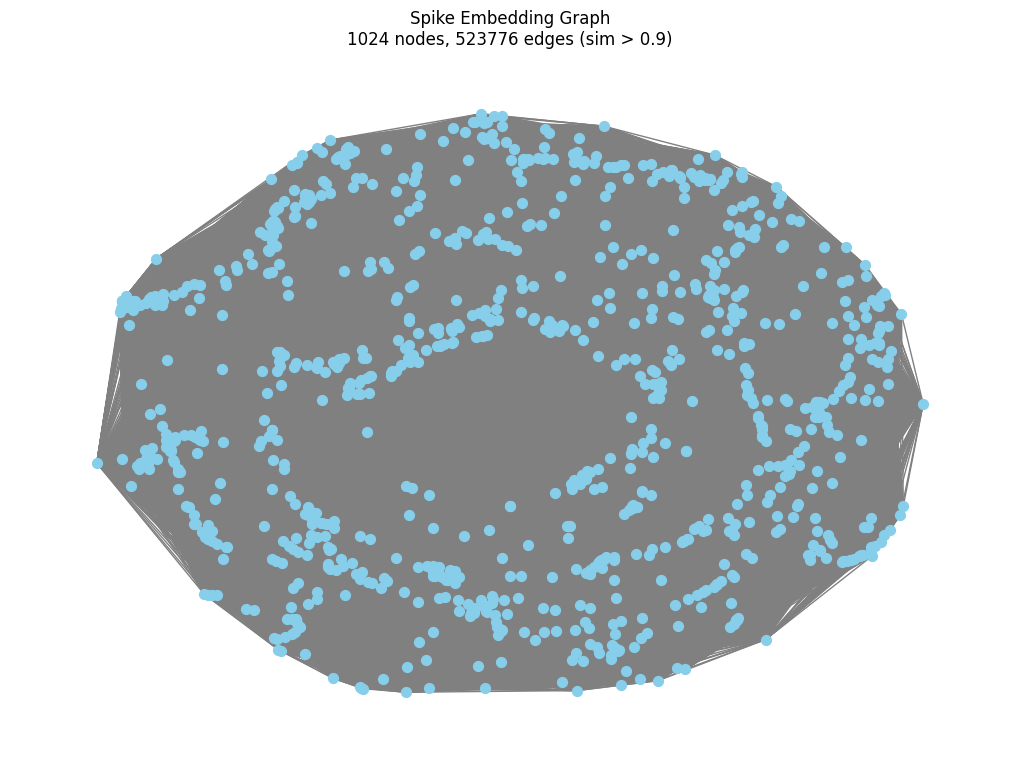

In [48]:
#visualize the graph
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load compressed features
embeddings = np.load("compressed_embeddings.npy")

# Build similarity-based graph
G = nx.Graph()
for i, vec in enumerate(embeddings):
    G.add_node(i, feature=vec)

# Add edges by similarity
similarity = cosine_similarity(embeddings)
threshold = 0.9  # you can test 0.85, 0.95 for different densities
for i in range(len(embeddings)):
    for j in range(i + 1, len(embeddings)):
        if similarity[i, j] > threshold:
            G.add_edge(i, j, weight=similarity[i, j])

# Layout and draw
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 7))
nx.draw(G, pos, node_size=50, edge_color='gray', node_color='skyblue', with_labels=False)
plt.title(f"Spike Embedding Graph\n{G.number_of_nodes()} nodes, {G.number_of_edges()} edges (sim > {threshold})")
plt.show()


In [49]:
#2A Normalize features for angle embeddings
import torch

# Normalize embeddings to [0, π] for RX/RZ angle embedding
features = torch.tensor(embeddings, dtype=torch.float32)
features_norm = (features - features.min()) / (features.max() - features.min()) * torch.pi
print("Angle-normalized features:", features_norm.shape)


Angle-normalized features: torch.Size([1024, 16])


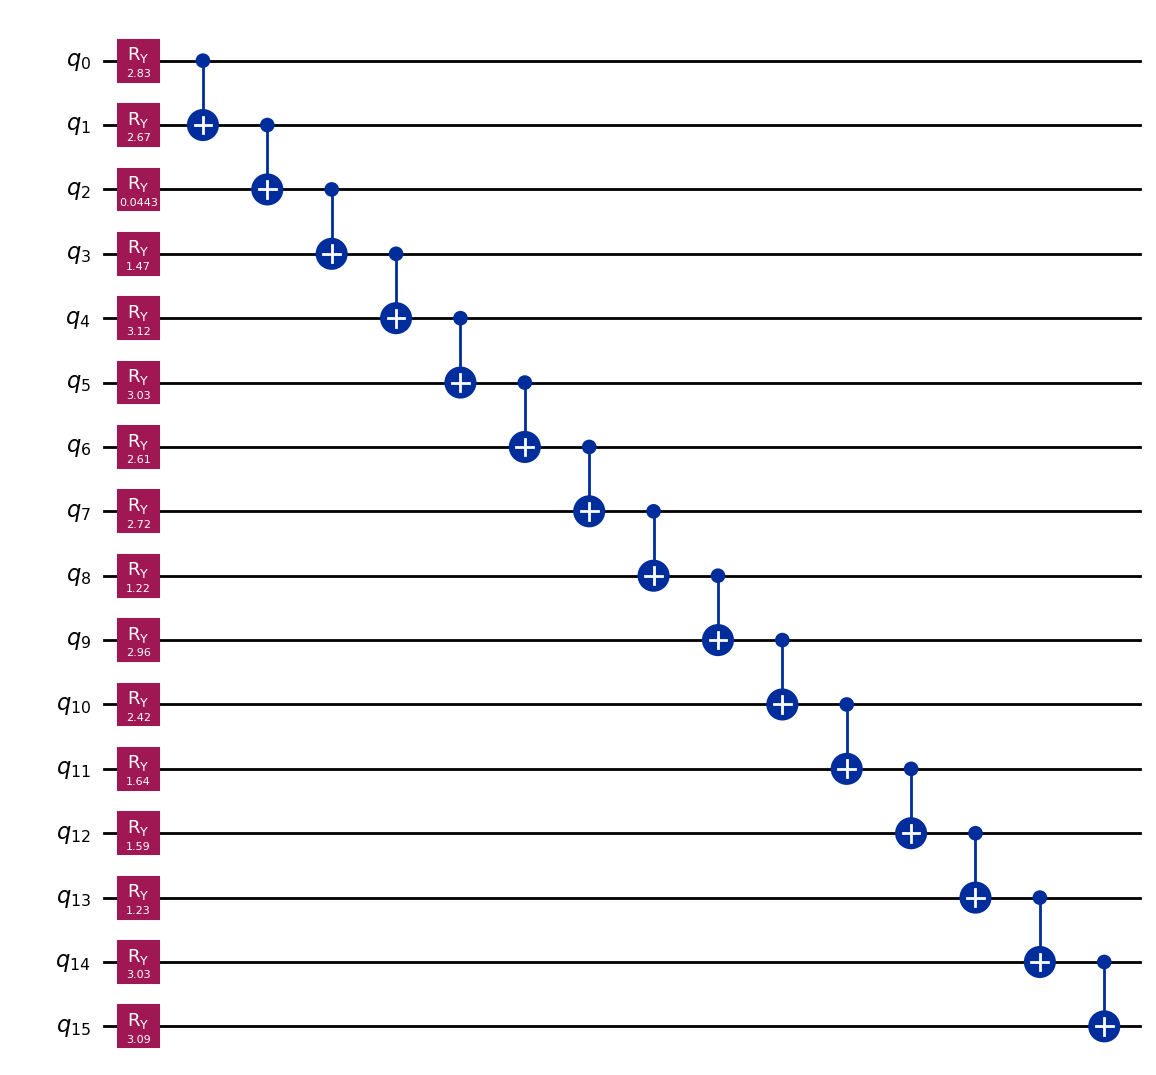

In [ ]:
#2B. Build a Parametrized Qiskit Circuit for Each Node
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

def build_node_circuit(feature_vector):
    n = len(feature_vector)
    qc = QuantumCircuit(n)

    # Encode features with RX or RY
    for i, angle in enumerate(feature_vector):
        qc.ry(angle.item(), i)

    # Entangle neighboring qubits (message passing)
    for i in range(n - 1):
        qc.cx(i, i + 1)

    return qc

# Example: visualize the circuit for node 0
qc0 = build_node_circuit(features_norm[0])
qc0.draw()


In [75]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between embeddings
sim_matrix = cosine_similarity(features_norm)  # (1024, 1024)

# Threshold the similarity matrix to create an adjacency matrix
threshold = 0.9
adj_matrix = (sim_matrix > threshold).astype(float)
np.fill_diagonal(adj_matrix, 0)  # Remove self-loops

# Convert to torch tensor and save for later use
adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
torch.save(adj_matrix, "adj_matrix.pt")

# Convert to PyG format
from torch_geometric.utils import dense_to_sparse
edge_index, _ = dense_to_sparse(adj_matrix)
print("✅ Adjacency matrix shape:", adj_matrix.shape)


✅ Adjacency matrix shape: torch.Size([1024, 1024])


In [77]:
from sklearn.neighbors import kneighbors_graph

# Build a k-nearest neighbor graph
knn_graph = kneighbors_graph(features_norm, n_neighbors=10, mode='connectivity', include_self=False)
adj_matrix = torch.tensor(knn_graph.toarray(), dtype=torch.float32)
torch.save(adj_matrix, "adj_matrix.pt")

edge_index, _ = dense_to_sparse(adj_matrix)
print("✅ k-NN adjacency matrix shape:", adj_matrix.shape)



✅ k-NN adjacency matrix shape: torch.Size([1024, 1024])


In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Sampler

class QGNNLayer(nn.Module):
    def __init__(self, in_dim, circuit, shots=1024):
        super().__init__()
        self.in_dim = in_dim
        # one scalar readout weight per qubit (could be learned)
        self.readout = nn.Parameter(torch.randn(in_dim))
        self.shots = shots

        # Qiskit setup
        sampler = Sampler()
        result = sampler.run(circuit, shots=200).result()
        quasi_dists = result.quasi_dists
        # convert keys to binary bitstrings
        binary_dist = quasi_dists[0].binary_probabilities()
 
        print("Quasi-dists: ", quasi_dists)
        print("Result: ", result)
        print("Binary quasi-dist: ", binary_dist)

        # backend = Aer.get_backend('aer_simulator_statevector')
        # self.quantum_instance = QuantumInstance(backend, shots=self.shots)
        # self.expectation = ExpectationFactory.build(
        #     operator=PauliZ(), backend=self.quantum_instance
        # )

    def normalize_angles(self, vec: torch.Tensor) -> torch.Tensor:
        # vec: [in_dim]
        v_min, v_max = vec.min(), vec.max()
        # avoid division by zero
        if (v_max - v_min).abs() < 1e-6:
            return torch.zeros_like(vec)
        return (vec - v_min) / (v_max - v_min) * torch.pi

    def build_node_circuit(self, angles: torch.Tensor) -> QuantumCircuit:
        n = angles.size(0)
        qc = QuantumCircuit(n)
        for q in range(n):
            theta = float(angles[q].item())
            # alternate RX/RY for diversity
            if q % 2 == 0:
                qc.rx(theta, q)
            else:
                qc.ry(theta, q)
        # simple chain entanglement
        for q in range(n - 1):
            qc.cx(q, q + 1)
        return qc

    def forward(self, X: torch.Tensor, A_norm: torch.Tensor) -> torch.Tensor:
    
        N = X.size(0)
        out = []

        # Step 1: aggregate neighbor features
        agg_all = A_norm @ X  # [N, in_dim]

        sampler = Sampler()

        for i in range(N):
            vec = agg_all[i]  # [in_dim]
            angles = self.normalize_angles(vec)
            qc = self.build_node_circuit(angles)

            # Define PauliZ observable on qubit 0
            obs = SparsePauliOp.from_list([("Z" + "I" * (self.in_dim - 1), 1.0)])

            # Run the circuit and get expectation value
            job = sampler.run(circuits=[qc], observables=[obs], shots=self.shots)
            result = job.result()
            exp_val = result.expectation_values[0].value  # real scalar

            # Multiply by readout weight for this node
            scalar = (self.readout * exp_val).sum()
            out.append(scalar)

        # Return as [N, 1]
        return torch.stack(out).unsqueeze(1)

In [ ]:
#complete the QGNN model



In [ ]:
# Classical Baseline - Graph Convolutional Network (GCN) baseline using PyTorch Geometric
#ensure  torch geometric is intalled

In [59]:
#Build the Dataset for GCN
import torch
from torch_geometric.data import Data
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

# Load node features
x = torch.tensor(np.load("compressed_embeddings.npy"), dtype=torch.float32)

# Build graph again to get edge index
similarity = cosine_similarity(x)
edge_index = []
threshold = 0.9

for i in range(len(x)):
    for j in range(i+1, len(x)):
        if similarity[i, j] > threshold:
            edge_index.append([i, j])
            edge_index.append([j, i])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Build PyG data object
data = Data(x=x, edge_index=edge_index)
print(data)


Data(x=[1024, 16], edge_index=[2, 1047552])


In [60]:
# 3. Define and Train a Simple GCN
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize model
gcn = GCN(in_channels=16, hidden_channels=32, out_channels=2)  # for visualization
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

# Self-supervised: reconstruct neighborhood similarities
gcn.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = gcn(data)
    loss = loss_fn(out, x[:, :2])  # optional proxy loss
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 1784.0682
Epoch 10 | Loss: 128.9506
Epoch 20 | Loss: 2.8748
Epoch 30 | Loss: 20.2094
Epoch 40 | Loss: 2.4959
Epoch 50 | Loss: 0.6938
Epoch 60 | Loss: 0.9757
Epoch 70 | Loss: 0.1344
Epoch 80 | Loss: 0.0081
Epoch 90 | Loss: 0.0353


In [ ]:
#Add loss validation code 

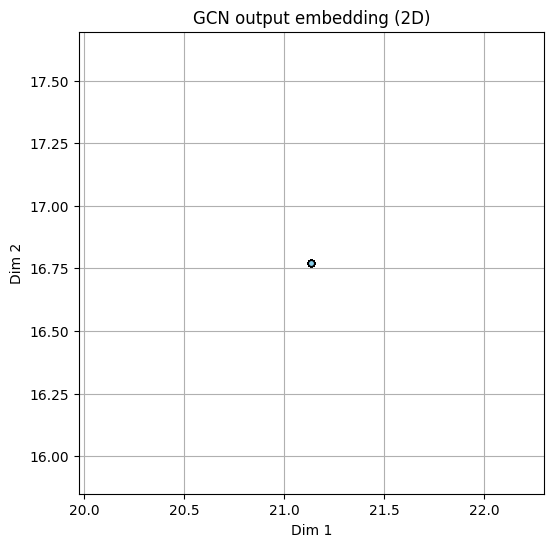

In [53]:
#4. Visualize GCN Output Embeddings (2D)
import matplotlib.pyplot as plt

gcn.eval()
with torch.no_grad():
    out = gcn(data)

out_np = out.numpy()
plt.figure(figsize=(6, 6))
plt.scatter(out_np[:, 0], out_np[:, 1], c='skyblue', s=20, edgecolors='k')
plt.title("GCN output embedding (2D)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()


In [15]:
#Baseline Metrics for CLassical model 


In [54]:
#Next Classical model for baseline 
#Best Next Classical Baseline: k-Means Clustering + Evaluation
# 1. Load Embeddings and Run k-Means


import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load embeddings from AE
embeddings = np.load("compressed_embeddings.npy")  # shape: (256, 16)

# Run k-means
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

# Evaluate clustering
sil_score = silhouette_score(embeddings, labels)
print(f"Silhouette Score (k-means on AE embeddings): {sil_score:.3f}")


Silhouette Score (k-means on AE embeddings): 0.744


c:\Users\synap\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


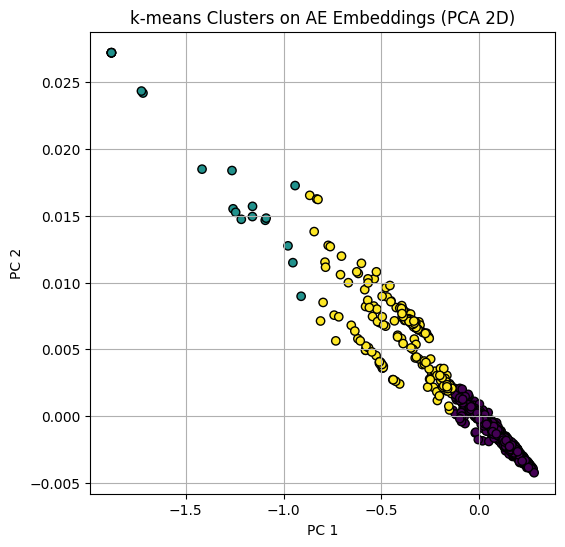

Silhouette Score: 0.744


In [55]:
#Visualize k-means clusters in 2D
# Reduce to 2D for plotting
pca = PCA(n_components=2)
proj = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='viridis', edgecolors='k')
plt.title("k-means Clusters on AE Embeddings (PCA 2D)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()
print(f"Silhouette Score: {sil_score:.3f}")


In [72]:
#PCA to justify embedding 
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(embeddings)
explained_var = np.sum(pca.explained_variance_ratio_)
print(f"PCA explained variance (2D): {explained_var:.2%}")


PCA explained variance (2D): 98.65%


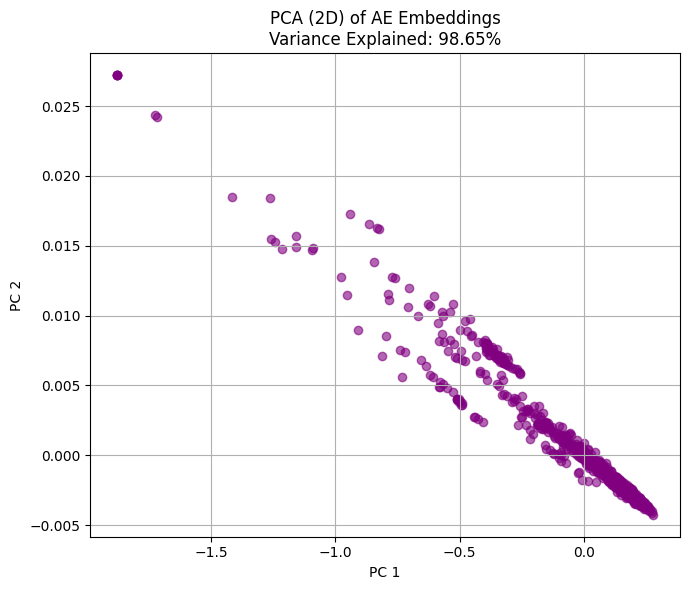

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

embeddings = np.load("compressed_embeddings.npy")

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

plt.figure(figsize=(7, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='purple', alpha=0.6)
plt.title(f"PCA (2D) of AE Embeddings\nVariance Explained: {np.sum(pca.explained_variance_ratio_):.2%}")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()
